In [108]:
from IPython import get_ipython
from keras import backend as K

In [109]:
# destroy the current TF graph and create a new one
# useful to avoid clutter from old models/layers
K.clear_session()

cfg=K.tf.ConfigProto()
cfg.gpu_options.allow_growth=True
K.set_session(K.tf.Session(config=cfg))


# clear all variables created
get_ipython().magic('reset -sf')

In [110]:
import pandas as pd
from pandas import Series
import numpy as np
from numpy import polyfit
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils import plot_model
import time
import math
import keras.callbacks
from sklearn.metrics import mean_squared_error,r2_score
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from scipy.stats.stats import pearsonr


In [111]:
#series = pd.read_csv('sine-wave.csv', header=None )
series=pd.read_csv('/home/xiao/data/ncdc_oisst_v2_avhrr_east_china_sea_32.125N_126.125E_19820101-20171231.csv',sep=';',usecols=[7],engine='python',skiprows=[0])
#print(dataframe.head())

#dataset=dataframe.values
#dataset=dataset.astype('float32')

In [112]:
series.head()

,16.27
0,16.24
1,16.26
2,16.00
3,15.94
4,15.12


In [113]:
series.shape

(13148, 1)

In [114]:
series.describe()

,16.27
count,13148.000000
mean,19.815800
std,5.181369
min,9.400000
25%,14.960000
50%,19.560000
75%,24.340000
max,31.000000


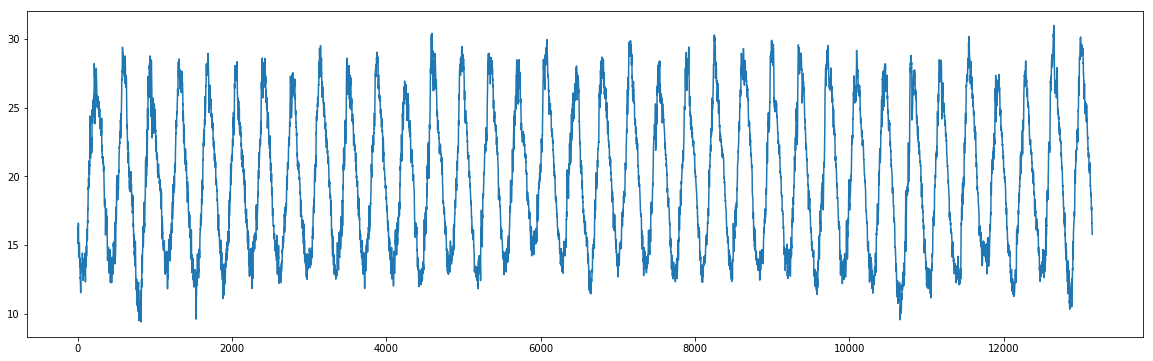

In [115]:
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values)
pyplot.show()

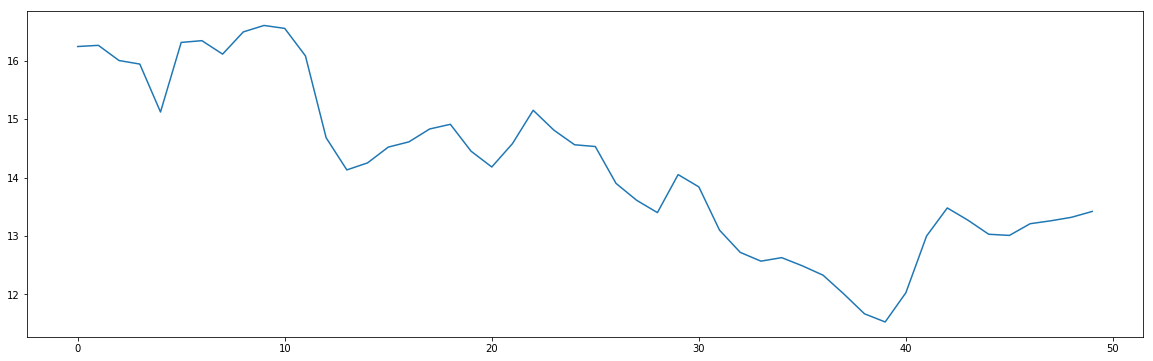

In [116]:
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values[:50])
pyplot.show()

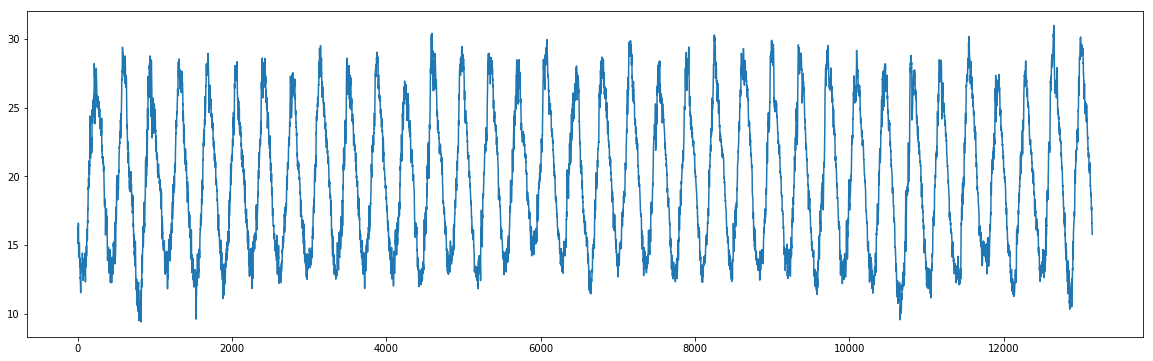

In [117]:
# plot orignial time series
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values)
pyplot.show()

In [118]:
# normalize features - 

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(series.values)
series = pd.DataFrame(scaled)

In [119]:
window_size = 50

series_s = series.copy()
print(series.shape)
for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
    
series.dropna(axis=0, inplace=True)

(13148, 1)


In [120]:
series.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.316667,0.317593,0.305556,0.302778,0.264815,0.319907,0.321296,0.310648,0.328241,0.333333,...,0.166667,0.188889,0.179167,0.168056,0.167130,0.176389,0.178704,0.181481,0.186111,0.180556
1,0.317593,0.305556,0.302778,0.264815,0.319907,0.321296,0.310648,0.328241,0.333333,0.331019,...,0.188889,0.179167,0.168056,0.167130,0.176389,0.178704,0.181481,0.186111,0.180556,0.174537
2,0.305556,0.302778,0.264815,0.319907,0.321296,0.310648,0.328241,0.333333,0.331019,0.309259,...,0.179167,0.168056,0.167130,0.176389,0.178704,0.181481,0.186111,0.180556,0.174537,0.173148
3,0.302778,0.264815,0.319907,0.321296,0.310648,0.328241,0.333333,0.331019,0.309259,0.244444,...,0.168056,0.167130,0.176389,0.178704,0.181481,0.186111,0.180556,0.174537,0.173148,0.196296
4,0.264815,0.319907,0.321296,0.310648,0.328241,0.333333,0.331019,0.309259,0.244444,0.218981,...,0.167130,0.176389,0.178704,0.181481,0.186111,0.180556,0.174537,0.173148,0.196296,0.193981


In [121]:
series.shape

(13098, 51)

In [122]:
nrow = round(0.8*series.shape[0])

In [123]:
train = series.iloc[:nrow, :]
test = series.iloc[nrow:,:]

In [124]:
from sklearn.utils import shuffle
train = shuffle(train)

In [125]:
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [126]:
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values

In [127]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(10478, 50)
(10478,)
(2620, 50)
(2620,)


In [128]:
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

In [129]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(10478, 50, 1)
(10478,)
(2620, 50, 1)
(2620,)


In [130]:
# Define the LSTM model
model = Sequential()
# input_shape is the shape of inputs for the network, representing (time steps,features)
# output_dim is the number of nurons in this LSTM layer.
# if return_sequence is set to True, then each nueron will output a sequence the same size of input sequence
model.add(LSTM(input_shape = (window_size,1), output_dim= 50, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(256))
#model.add(LSTM(256,return_sequences=True))
model.add(Dropout(0.5))
#model.add(LSTM(256))
#model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
tensorboard=keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
model.summary()
plot_model(model,to_file='model.png')

/home/xiao/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, input_shape=(50, 1), return_sequences=True)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 325,025
Trainable params: 325,025
Non-trainable params: 0
_________________________________________________________________


In [131]:
start = time.time()
model.fit(train_X,train_y,batch_size=512,nb_epoch=10,validation_split=0.1,callbacks=[tensorboard])
print("> Compilation Time : ", time.time() - start)

/home/xiao/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 9430 samples, validate on 1048 samples
Epoch 1/10
9430/9430 [==============================] - 6s 639us/step - loss: 0.0455 - val_loss: 0.0064
Epoch 2/10
9430/9430 [==============================] - 6s 598us/step - loss: 0.0069 - val_loss: 0.0027
Epoch 3/10
9430/9430 [==============================] - 6s 598us/step - loss: 0.0049 - val_loss: 0.0017
Epoch 4/10
9430/9430 [==============================] - 6s 599us/step - loss: 0.0044 - val_loss: 0.0017
Epoch 5/10
9430/9430 [==============================] - 6s 619us/step - loss: 0.0042 - val_loss: 0.0018
Epoch 6/10
9430/9430 [==============================] - 6s 667us/step - loss: 0.0042 - val_loss: 0.0016
Epoch 7/10
9430/9430 [==============================] - 6s 656us/step - loss: 0.0039 - val_loss: 0.0016
Epoch 8/10
9430/9430 [==============================] - 6s 633us/step - loss: 0.0038 - val_loss: 0.0015
Epoch 9/10
9430/9430 [==============================] - 6s 671us/step - loss: 0.0036 - val_loss: 0.0015
Epoch 10/10
9430

In [132]:
# Doing a prediction on all the test data at once
preds = model.predict(test_X)

In [133]:
preds = scaler.inverse_transform(preds)

In [134]:
actuals = scaler.inverse_transform(test_y.reshape(-1,1)) #xcj added reshape part

In [135]:
math.sqrt(mean_squared_error(actuals,preds))

0.8995396359987837

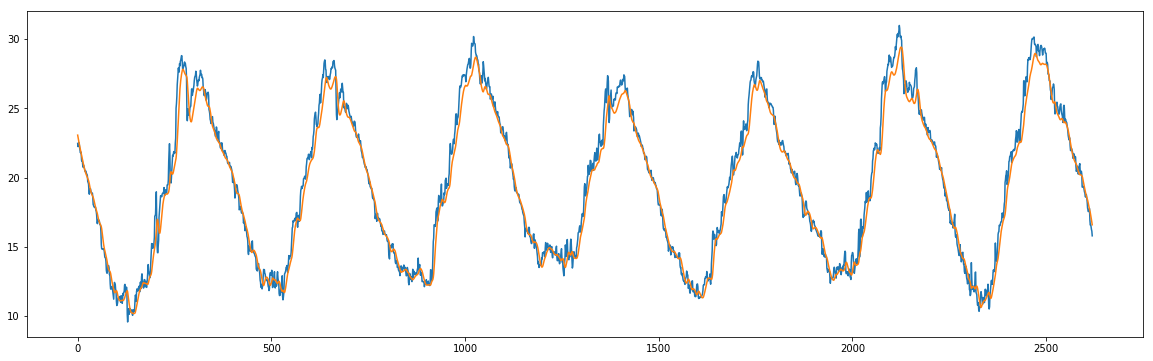

In [136]:
pyplot.figure(figsize=(20,6))
pyplot.plot(actuals)
pyplot.plot(preds)
pyplot.show()

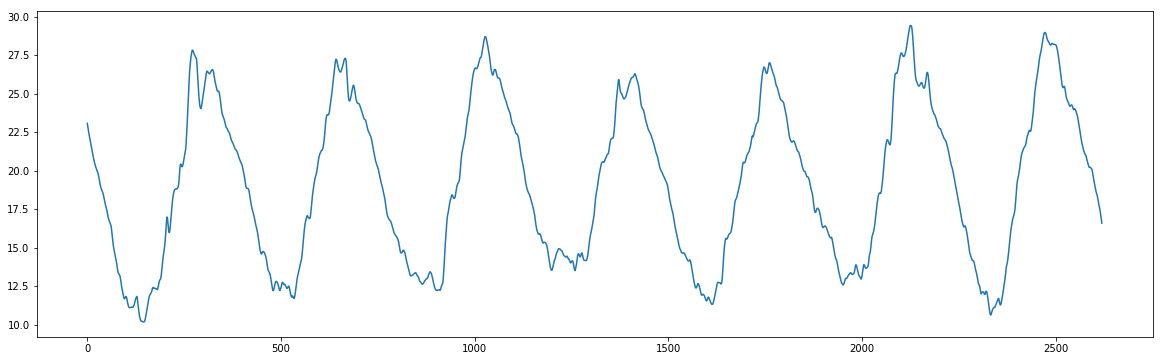

In [137]:
pyplot.figure(figsize=(20,6))
pyplot.plot(preds)
pyplot.show()

In [138]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window. It's in colume form.
    moving_test_window = [test_X[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    #shape_moving_test_window=moving_test_window.shape    # added by xcj
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        #moving_test_window=scaler.fit_transform(moving_test_window[0,:]) # added by xcj
        #moving_test_window=moving_test_window.reshape(shape_moving_test_window) # added by xcj
        
    preds_moving=np.array(preds_moving) # xcj added
    # print(preds_moving.shape)
    preds_moving = scaler.inverse_transform(preds_moving.reshape(preds_moving.shape[0],1)) # xcj added reshape part
    
    return preds_moving
        

In [139]:
n_future_preds=28
preds_moving = moving_test_window_preds(n_future_preds)
# print(preds_moving)

In [140]:
# calculate statistics
actuals_sub=actuals[0:n_future_preds,0]
preds=preds_moving[:,0]

RMSE=math.sqrt(mean_squared_error(actuals_sub,preds))
print('RMSE: %f'%(RMSE))

r,pvalue=pearsonr(actuals_sub,preds)
print('Pearson\'s Correlation coefficient: %f, p-value: %f'%(r,pvalue))

RMSE: 0.576909
Pearson's Correlation coefficient: 0.981950, p-value: 0.000000


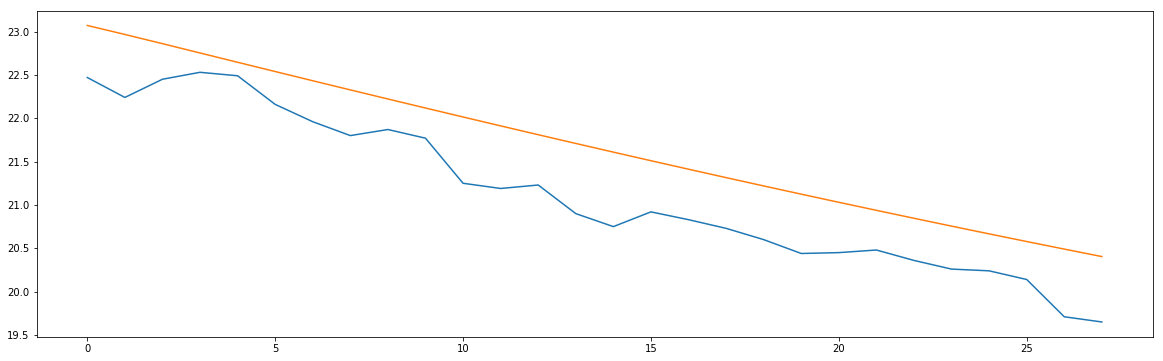

In [143]:
pyplot.figure(figsize=(20,6))
pyplot.plot(actuals_sub)
pyplot.plot(preds_moving) 
pyplot.show()

Coefficients:1.07
Intercept:-1.97
RMSE: 0.165
Variance score (R-square):0.964


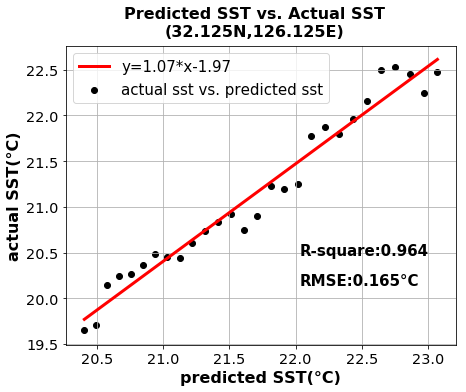

In [142]:
# make linear regressions between acutals and predicts
regr=linear_model.LinearRegression()
regr.fit(preds.reshape(-1,1),actuals_sub.reshape(-1,1))
fit_value=regr.predict(preds.reshape(-1,1))

intercept=regr.intercept_
coef=regr.coef_[0,0]
rmse=math.sqrt(mean_squared_error(actuals_sub,fit_value))
r2=r2_score(actuals_sub,fit_value)

print('Coefficients:%.2f'%coef)
print('Intercept:%.2f'%intercept)
print('RMSE: %.3f'%rmse)
print('Variance score (R-square):%.3f'%r2)

# plot the regression
fig,ax=pyplot.subplots(figsize=(7,5.5))
fig.suptitle('Predicted SST vs. Actual SST\n(32.125N,126.125E)',fontsize=16,fontweight='bold')
ax.scatter(preds,actuals_sub,color='black',label='actual sst vs. predicted sst')
if intercept>0:
    ax.plot(preds,fit_value,color='red',linewidth=3,label='y=%.2f*x+%.2f'%(coef,intercept))
elif intercept<0:
    ax.plot(preds,fit_value,color='red',linewidth=3,label='y=%.2f*x-%.2f'%(coef,abs(intercept)))
else:
    ax.plot(preds,fit_value,color='red',linewidth=3,label='y=%.2f*x'%(coef))

# set x,y label
ax.set_xlabel(xlabel='predicted SST(\u00B0C)',
              fontsize=16,
              fontweight='bold')
ax.set_ylabel(ylabel='actual SST(\u00B0C)',
              fontsize=16,
              fontweight='bold')

# add text
ax.text(0.6,0.3,
        'R-square:%.3f'%(r2),
        fontsize=15,
        fontweight='bold',
        transform=ax.transAxes)
ax.text(0.6,0.2,
        'RMSE:%.3f\u00B0C'%(rmse),
        fontsize=15,
        fontweight='bold',
        transform=ax.transAxes)
pyplot.setp(ax.get_xticklabels(),fontsize=14.5)
pyplot.setp(ax.get_yticklabels(),fontsize=14.5)

# add grid
ax.grid()

# add legend
#legend=ax.legend(loc='upper left',fontsize=15,prop={'weight':'bold'})
legend=ax.legend(loc='upper left',fontsize=15)

# show plot
pyplot.show()